# 04 - Baseline Modeling dengan TF-IDF

Pada tahap ini dilakukan pemodelan baseline menggunakan representasi TF-IDF yang dikombinasikan dengan beberapa algoritma klasifikasi klasik, yaitu:

- **Logistic Regression**
- **Linear Support Vector Machine (Linear SVM)**
- **Multinomial Naive Bayes**

Model-model ini akan dijadikan pembanding (baseline) terhadap model berbasis **IndoBERT** pada tahap selanjutnya.

## 04.1 - Data yang Digunakan

Data yang digunakan pada tahap ini berasal dari file:

- `data/dataset_preprocessed.csv`

Dengan kolom penting:

- `stemming_data` : hasil preprocessing lengkap (cleaning, stopword removal, stemming) → digunakan sebagai fitur teks untuk TF-IDF.
- `sentiment` : label kelas (`negative`, `neutral`, `positive`).
- `label` : versi numerik dari label sentimen (0 = negative, 1 = neutral, 2 = positive).

## 04.2 - Tahapan Modeling

1. Membaca dataset preprocessing.
2. Memisahkan fitur (`X`) dan label (`y`).
3. Membagi data menjadi data latih dan data uji (train–test split) secara stratified.
4. Mengubah teks menjadi vektor numerik menggunakan **TF-IDF** (unigram + bigram).
5. Menangani ketidakseimbangan kelas (class imbalance) dengan **RandomOverSampler** pada data latih.
6. Melatih tiga model:
   - Logistic Regression
   - Linear SVM
   - Multinomial Naive Bayes
7. Mengevaluasi model menggunakan:
   - Accuracy
   - Precision, Recall, F1-score (macro)
   - Confusion matrix
8. Membandingkan performa ketiga model sebagai baseline.


----

## Import Library

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix

## Import Dataset

In [10]:
df = pd.read_csv("../data/dataset_preprocessed.csv")

In [11]:
df.head()

,comment,cleaning,case_folding,normalisasi,tokenize,stopword removal,stemming_data,sentiment,label
0,Yg benci ya apa aja salah.. \nYg seneng ya mak...,Yg benci ya apa aja salah \nYg seneng ya makin...,yg benci ya apa aja salah \nyg seneng ya makin...,yang benci ya apa saja salah yang senang ya ma...,"['yang', 'benci', 'ya', 'apa', 'saja', 'salah'...","['benci', 'ya', 'salah', 'senang', 'ya', 'sena...",benci ya salah senang ya senang nyinyir ya bah...,neutral,1
1,Bandung akan miliki kereta pajajaran dgn beaya...,Bandung akan miliki kereta pajajaran dgn beaya...,bandung akan miliki kereta pajajaran dgn beaya...,bandung akan miliki kereta pajajaran dengan be...,"['bandung', 'akan', 'miliki', 'kereta', 'pajaj...","['bandung', 'miliki', 'kereta', 'pajajaran', '...",bandung milik kereta pajajaran beaya murah who...,neutral,1
2,SUDAH JELAS GENG SOLO YANG HARUS BERTANGGUNG J...,SUDAH JELAS GENG SOLO YANG HARUS BERTANGGUNG J...,sudah jelas geng solo yang harus bertanggung j...,sudah jelas geng solo yang harus bertanggung j...,"['sudah', 'jelas', 'geng', 'solo', 'yang', 'ha...","['geng', 'solo', 'bertanggung', 'tangkap']",geng solo tanggung tangkap,negative,0
3,"Jokowi, Luhut, kroni2 yg harus bertanggungjaw...",Jokowi Luhut kroni yg harus bertanggungjawab ...,jokowi luhut kroni yg harus bertanggungjawab ...,jokowi luhut kroni yang harus bertanggungjawab...,"['jokowi', 'luhut', 'kroni', 'yang', 'harus', ...","['jokowi', 'luhut', 'kroni', 'bertanggungjawab...",jokowi luhut kroni bertanggungjawab bayar huta...,negative,0
4,Yg ditangkap gorengan yg makan duduk manis,Yg ditangkap gorengan yg makan duduk manis,yg ditangkap gorengan yg makan duduk manis,yang ditangkap gorengan yang makan duduk manis,"['yang', 'ditangkap', 'gorengan', 'yang', 'mak...","['ditangkap', 'gorengan', 'makan', 'duduk', 'm...",tangkap goreng makan duduk manis,neutral,1


## Cek Kolom

In [12]:
df.columns

Index(['comment', 'cleaning', 'case_folding', 'normalisasi', 'tokenize',
       'stopword removal', 'stemming_data', 'sentiment', 'label'],
      dtype='object')

## Pisahkan Fitur & Label + Train-Test Split

In [13]:
X = df["stemming_data"]      # teks final untuk TF-IDF
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

len(X_train), len(X_test)

(789, 198)

## TF-IDF Vectorizer

In [14]:
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),     # unigram + bigram
    min_df=3,
    max_features=10000,
    sublinear_tf=True
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

X_train_tfidf.shape, X_test_tfidf.shape

((789, 604), (198, 604))

## Oversampling di Training Set

In [17]:
ros = RandomOverSampler(random_state=42)

X_train_resampled, y_train_resampled = ros.fit_resample(X_train_tfidf, y_train)

unique, counts = np.unique(y_train_resampled, return_counts=True)
dict(zip(unique, counts))

{0: 516, 1: 516, 2: 516}

## Train 3 Model: Logistic Regression, Linear Support Vector Machine, Multinomial Naive Bayes

In [19]:
models = {}

# 1. Logistic Regression
logreg = LogisticRegression(
    max_iter=500,
    class_weight="balanced",
    solver="liblinear"
)
logreg.fit(X_train_resampled, y_train_resampled)
models["Logistic Regression"] = logreg

# 2. Linear SVM
svm = LinearSVC(
    class_weight="balanced",
    random_state=42
)
svm.fit(X_train_resampled, y_train_resampled)
models["Linear SVM"] = svm

# 3. Multinomial Naive Bayes
mnb = MultinomialNB()
mnb.fit(X_train_resampled, y_train_resampled)
models["Multinomial NB"] = mnb

c:\Users\hafizh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


## Evaluasi Semua Model

In [21]:
results = []

for name, model in models.items():
    y_pred = model.predict(X_test_tfidf)
    
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")
    
    print("="*60)
    print(name)
    print(f"Accuracy   : {acc:.4f}")
    print(f"F1 Macro   : {f1_macro:.4f}")
    print("\nClassification Report:")
    print(classification_report(
        y_test, y_pred,
        target_names=["negative", "neutral", "positive"]
    ))
    
    results.append({
        "model": name,
        "accuracy": acc,
        "f1_macro": f1_macro
    })

results_df = pd.DataFrame(results)
results_df

Logistic Regression
Accuracy   : 0.6414
F1 Macro   : 0.4527

Classification Report:
              precision    recall  f1-score   support

    negative       0.78      0.73      0.76       129
     neutral       0.50      0.52      0.51        62
    positive       0.07      0.14      0.10         7

    accuracy                           0.64       198
   macro avg       0.45      0.46      0.45       198
weighted avg       0.67      0.64      0.65       198

Linear SVM
Accuracy   : 0.6061
F1 Macro   : 0.4084

Classification Report:
              precision    recall  f1-score   support

    negative       0.80      0.67      0.73       129
     neutral       0.45      0.55      0.50        62
    positive       0.00      0.00      0.00         7

    accuracy                           0.61       198
   macro avg       0.42      0.41      0.41       198
weighted avg       0.67      0.61      0.63       198

Multinomial NB
Accuracy   : 0.5556
F1 Macro   : 0.4084

Classification Report:


,model,accuracy,f1_macro
0,Logistic Regression,0.641414,0.452732
1,Linear SVM,0.606061,0.408388
2,Multinomial NB,0.555556,0.408354


## Confusion Matrix untuk Model Terbaik

<Figure size 500x500 with 0 Axes>

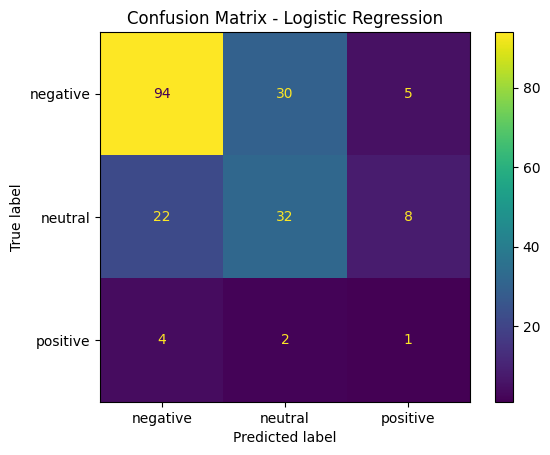

In [25]:
best_name = results_df.sort_values("f1_macro", ascending=False).iloc[0]["model"]
best_model = models[best_name]

y_pred_best = best_model.predict(X_test_tfidf)

cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["negative", "neutral", "positive"]
)

plt.figure(figsize=(5, 5))
disp.plot(values_format="d")
plt.title(f"Confusion Matrix - {best_name}")
plt.show()

## Melihat kata paling berpengaruh per kelas

In [30]:
tfidf = tfidf  # vectorizer kamu
clf = logreg   # model kamu

feature_names = tfidf.get_feature_names_out()
coefs = clf.coef_
classes = clf.classes_

In [31]:
n_top = 20

for i, label in enumerate(classes):
    coef = coefs[i]
    top_idx = np.argsort(coef)[-n_top:]
    top_words = [feature_names[j] for j in top_idx]
    top_coefs = coef[top_idx]

    print(f"\n=== Top {n_top} kata untuk kelas: {label} ===")
    for word, c in zip(reversed(top_words), reversed(top_coefs)):
        print(f"{word:20} : {c:8.4f}")


=== Top 20 kata untuk kelas: 0 ===
bayar                :   2.1919
usut                 :   2.1487
adil                 :   2.1233
tangkap              :   1.9346
negeri               :   1.7571
utang                :   1.6853
maling               :   1.6406
kpk                  :   1.6031
koruptor             :   1.5815
jokowi               :   1.5375
hutang               :   1.5045
manusia              :   1.5005
rugi                 :   1.4797
bpk                  :   1.4763
libat                :   1.4625
takut                :   1.4508
termul               :   1.3257
ganti                :   1.2982
joko                 :   1.2939
rakyat               :   1.2625

=== Top 20 kata untuk kelas: 1 ===
aiman                :   1.4928
panggil              :   1.4854
kasih                :   1.4699
suara                :   1.4038
atas                 :   1.3351
bicara               :   1.3341
politik              :   1.3147
dengar               :   1.3009
kerja                :   1.2674


## Fungsi Prediksi

In [32]:
def prediksi_sentimen(teks):
    vector = tfidf.transform([teks])
    pred = clf.predict(vector)[0]
    prob = clf.predict_proba(vector)[0]

    print(f"Teks: {teks}")
    print(f"Prediksi: {pred}")
    print(f"Probabilitas: {dict(zip(classes, prob))}")
    print("-" * 50)

In [40]:
prediksi_sentimen("kereta cepat whoosh keren banget")
prediksi_sentimen("ini proyek yang sangat merugikan negara")
prediksi_sentimen("biasa aja sih, ga terlalu relevan")
prediksi_sentimen("keren banget whoosh")

Teks: kereta cepat whoosh keren banget
Prediksi: 1
Probabilitas: {0: 0.35596185208918124, 1: 0.42714221146102294, 2: 0.2168959364497958}
--------------------------------------------------
Teks: ini proyek yang sangat merugikan negara
Prediksi: 0
Probabilitas: {0: 0.6083784201358473, 1: 0.21258604925061064, 2: 0.1790355306135421}
--------------------------------------------------
Teks: biasa aja sih, ga terlalu relevan
Prediksi: 1
Probabilitas: {0: 0.3398567435189311, 1: 0.6210336486967353, 2: 0.03910960778433361}
--------------------------------------------------
Teks: keren banget whoosh
Prediksi: 2
Probabilitas: {0: 0.18853730117696235, 1: 0.3718117258433964, 2: 0.4396509729796413}
--------------------------------------------------
